# The Grange, Edinburgh, Scotland

In [51]:
import warnings
warnings.filterwarnings("ignore")

from libs.tools import *
from libs.graph_route import plot_graph_route

import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

from network import Network
from network.algorithms import hierholzer
ox.config(use_cache=True, log_console=True)

from libs.gpx_formatter import TEMPLATE, TRACE_POINT
import datetime

2024-03-15 14:19:16 Configured osmnx


In [52]:
CUSTOM_FILTER = (
    '["highway"]["area"!~"yes"]["highway"!~"bridleway|bus_guideway|bus_stop|construction|cycleway|elevator|footway|'
    'motorway|motorway_junction|motorway_link|escalator|proposed|construction|platform|raceway|rest_area|'
    'path|service"]["access"!~"customers|no|private"]["public_transport"!~"platform"]'
    '["fee"!~"yes"]["foot"!~"no"]["service"!~"drive-through|driveway|parking_aisle"]["toll"!~"yes"]'
)

2024-03-15 14:19:19 Retrieved response from cache file "cache/094b7298b6b72a8017865ead2aba178e.json"
2024-03-15 14:19:19 Created GeoDataFrame with 1 rows from 1 queries
2024-03-15 14:19:19 Constructed place geometry polygon(s) to query API
2024-03-15 14:19:19 Projected GeoDataFrame to +proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2024-03-15 14:19:19 Projected GeoDataFrame to epsg:4326
2024-03-15 14:19:19 Projected GeoDataFrame to +proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2024-03-15 14:19:19 Projected GeoDataFrame to epsg:4326
2024-03-15 14:19:19 Requesting network data within polygon from API in 1 request(s)
2024-03-15 14:19:19 Retrieved response from cache file "cache/8ce8d58705429ee6aab6de398d9d99d5.json"
2024-03-15 14:19:19 Got all network data within polygon from API in 1 request(s)
2024-03-15 14:19:19 Creating graph from downloaded OSM data...
2024-03-15 14:19:19 Created graph with 3691 nodes and 7232 edges
2024-03-15 14:19

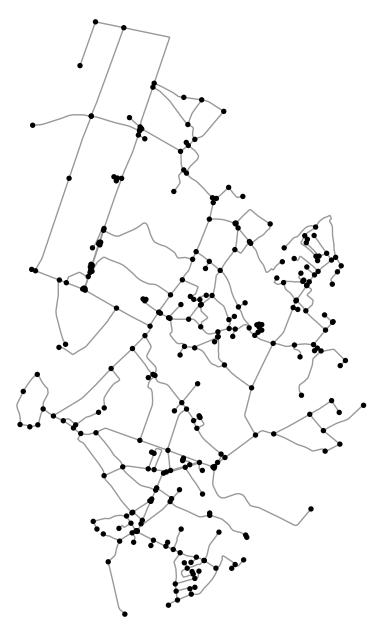

2024-03-15 14:19:20 Finished plotting the graph


In [53]:
location = "Saint-Georges-sur-Meuse, Belgium"
org_graph = ox.graph_from_place(location, custom_filter=CUSTOM_FILTER)

# Simplifying the original directed multi-graph to undirected, so we can go both ways in one way streets
graph = ox.utils_graph.get_undirected(org_graph)
fig, ax = ox.plot_graph(graph, node_zorder=2, node_color="k", bgcolor="w")

In [54]:
# Finds the odd degree nodes and minimal matching
odd_degree_nodes = get_odd_degree_nodes(graph)
pair_weights = get_shortest_distance_for_odd_degrees(graph, odd_degree_nodes)
matched_edges_with_weights = min_matching(pair_weights)

2024-03-15 14:19:40 Begin plotting the graph...
2024-03-15 14:19:40 Created edges GeoDataFrame from graph
2024-03-15 14:19:40 Created nodes GeoDataFrame from graph


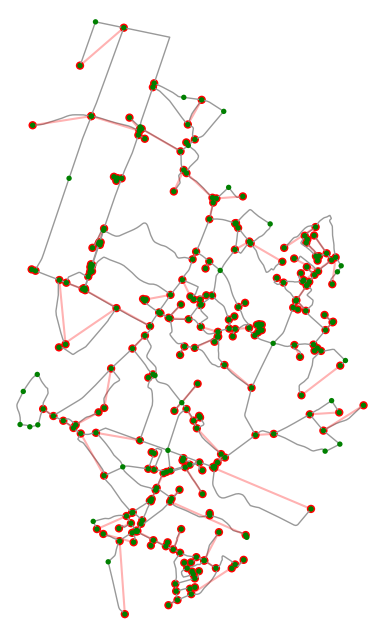

2024-03-15 14:19:40 Finished plotting the graph


In [55]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black', frameon=False)
for v, u, w in matched_edges_with_weights:
    x = graph.nodes[v]["x"], graph.nodes[u]["x"]
    y = graph.nodes[v]["y"], graph.nodes[u]["y"]
    ax.plot(x, y, c='red', alpha=0.3)
    ax.scatter(x, y, c='red', edgecolor="none")

fig, ax = ox.plot_graph(graph, node_zorder=2, node_color='g', bgcolor='k', ax=ax)

In [61]:
# List all edges of the extended graph including original edges and edges from minimal matching
single_edges = [(u, v) for u, v, k in graph.edges]
added_edges = get_shortest_paths(graph, matched_edges_with_weights)
edges = map_osmnx_edges2integers(graph, single_edges + added_edges)

# Finds the Eulerian path
network = Network(len(graph.nodes), edges, weighted=True)
eulerian_path = hierholzer(network)
converted_eulerian_path = convert_integer_path2osmnx_nodes(eulerian_path, graph.nodes())
double_edge_heap = get_double_edge_heap(org_graph)

# Finds the final path with edge IDs
final_path = convert_path(graph, converted_eulerian_path, double_edge_heap)
coordinates_path = convert_final_path_to_coordinates(org_graph, final_path)
#LINE NOT NEEDED FOR GPX: fig, ax = plot_graph_route(org_graph, final_path, route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="w")

# Route statistics from OSMnx 
ex = ox.extended_stats(org_graph, ecc=True)
center_node = org_graph.nodes[ex["center"][0]]
trace_points = "\n\t\t\t".join([TRACE_POINT.format(
    lat=lat, lon=lon, id=i, timestamp=datetime.datetime.today().isoformat()
) for i, (lat, lon) in enumerate(coordinates_path)])

gpx_payload = TEMPLATE.format(
    name="StGeorges",
    trace_points=trace_points,
    center_lat=center_node["y"],
    center_lon=center_node["x"]
)

with open("gpx_output.gpx", "w") as f:
    f.write(gpx_payload)

2024-03-15 14:24:21 Calculated shortest path lengths
2024-03-15 14:24:21 Calculated extended stats
